In [6]:
import os
import shutil
import sys
import subprocess
import requests
import json
import re
import time
import yt_dlp
import html
import time
from datetime import datetime
from dateutil import parser
from bs4 import BeautifulSoup
from urllib.parse import urlparse, quote_plus
import ffmpeg

# Function to check and load from cache
def check_cache(directory, filename):
    file_path = os.path.join(directory, filename)
    if os.path.exists(file_path):
        print(f'Loading from cache: {file_path}')
        with open(file_path, 'r') as file:
            return json.load(file)
    return None

# Function to save data to cache
def save_cache(directory, filename, data):
    file_path = os.path.join(directory, filename)
    file = open(file_path, 'w+')
    file.write(json.dumps(data, indent=4))
    file.close()

BASE_DIR = '/Users/bebeal/Programs/ProjectionSorcery'
CACHE_DIR = './cache'
STEAM_CACHE_DIR = os.path.join(CACHE_DIR, 'steam')
YOUTUBE_CACHE_DIR = os.path.join(CACHE_DIR, 'youtube')
REDDIT_JSON_CACHE_DIR = os.path.join(CACHE_DIR, 'reddit/json')
REDDIT_CONTENT_CACHE_DIR = os.path.join(CACHE_DIR, 'reddit')
os.makedirs(CACHE_DIR, exist_ok=True)
os.makedirs(STEAM_CACHE_DIR, exist_ok=True)
os.makedirs(YOUTUBE_CACHE_DIR, exist_ok=True)
os.makedirs(REDDIT_JSON_CACHE_DIR, exist_ok=True)
os.makedirs(REDDIT_CONTENT_CACHE_DIR, exist_ok=True)
MEDIA_LINK_CACHE='media_links.json'
MEDIA_LINKS_PATH = os.path.join(CACHE_DIR, MEDIA_LINK_CACHE)
media_links = []
if os.path.exists(MEDIA_LINKS_PATH):
    media_links = json.load(open(MEDIA_LINKS_PATH))
print(f"Loaded {len(media_links)} media links from cache")


Loaded 950 media links from cache


In [7]:
WE_APP_ID = 431960
headers = {'User-Agent': 'Mozilla/5.0'}
reddit_domain = 'https://www.reddit.com'
subreddit = 'wallpaperengine'
subreddit_url = f'{reddit_domain}/r/{subreddit}'
top_posts_url = f'{subreddit_url}/top/'
properties = ["title", "ups", "downs",  "score", "upvote_ratio", "total_awards_received", "secure_media", "media", "link_flair_text", "link_flair_richtext", "thumbnail", "post_hint", "created", "created_utc", "all_awardings", "id", "author", "num_comments", "permalink", "url", "is_video", "over_18", "is_reddit_media_domain"]
limit_per_request = 100

def get_top_posts(after=None, t='year'):
  url = f'{top_posts_url}.json?sort=top&t={t}&limit={limit_per_request}'
  if after:
    url = f'{url}&after={after}'
  # check cache
  cache_filename = f'{subreddit}_top_posts_{t}_{after if after else "default"}.json'
  top_posts = check_cache(REDDIT_JSON_CACHE_DIR, cache_filename)
  if not top_posts:
    response = requests.get(url, headers)
    if response.status_code == 200:
      print(f"Fetched {url}")
      top_posts = response.json()
      save_cache(REDDIT_JSON_CACHE_DIR, cache_filename, top_posts)
    else:
      print(f"Failed to fetch {url}", response.status_code, response.text)
      return []
  time.sleep(1)
  return top_posts
  
def get_n_top_posts(n):
  after = None
  all_posts = []
  num_requests = (n + limit_per_request - 1) // limit_per_request
  for i in range(num_requests):
    top_posts = get_top_posts(after)
    if len(top_posts) > 0 and 'data' in top_posts:
      after = top_posts['data']['after']
      post_listings = top_posts['data']['children']
      post_list = [{prop: post['data'][prop] for prop in properties if prop in post['data']} for post in post_listings]
      all_posts.extend(post_list)
  return all_posts

n = 1100
if len(media_links) <= 0:
  # filter out posts that are not videos
  media_links = [{
    "fallback_url": "https://steamcommunity.com/sharedfiles/filedetails/?id=3257943478",
    "height": 1080,
    "width": 1920,
  }]
  post_links = get_n_top_posts(n)
  media_links.extend([post['media']['reddit_video'] for post in post_links if post['is_video']])

# ensure uniqueness
unique_posts = {post['fallback_url']: post for post in media_links}
media_links = list(unique_posts.values())

print(f"Total video posts: {len(media_links)}")

Total video posts: 950


In [8]:
def download_youtube_video(video_id, dir=YOUTUBE_CACHE_DIR):
  path = os.path.join(dir, f'{video_id}')
  if not os.path.exists(path):
    # https://github.com/ytdl-org/youtube-dl/blob/master/youtube_dl/YoutubeDL.py#L157
    ydl_opts = {
      'outtmpl': f'{dir}/{video_id}',
      'format': "bv*[ext=mp4]+ba[ext=m4a]/b[ext=mp4] / bv*+ba/b" # Download the best mp4 video available, or the best video if no mp4 available
    }
    url = f'https://www.{youtube_domain}/watch?v={video_id}'
    yt_dlp.YoutubeDL(ydl_opts).download([url])
  else:
    print(f'Loading from cache: {path}')
  return path

def download_reddit_content(link, dir=REDDIT_CONTENT_CACHE_DIR):
  video_id = re.search(r'v\.redd\.it/([^/?]+)', link).group(1)
  path = os.path.join(dir, f'{video_id}.mp4')
  if not os.path.exists(path):
    response = requests.get(link, headers)
    if response.status_code == 200:
      file = open(path, 'wb')
      file.write(response.content)
      file.close()
    else:
      print(f"Failed to fetch {link}")
      return None
  else:
    print(f'Loading from cache: {path}')
  return path

def steam_workshop(workshop_id): return f'https://steamcommunity.com/sharedfiles/filedetails/?id={workshop_id}'
login = f"{os.environ['STEAM_USER']} {os.environ['STEAM_PASS']}" # ' anonymous' for anonymous login

def run_steamcmd(command):
    base_command = f"steamcmd +force_install_dir {BASE_DIR} +login {login}"
    full_command = f"{base_command} {command} +quit"
    result = subprocess.run(full_command, shell=True)
    return result.returncode

def check_steam_cache(dir, workshop_id):
    # check for any extension
    for ext in ['jpg', 'jpeg', 'png', 'mp4', 'webm', 'gif', 'pkg', 'json']:
        if os.path.exists(f'{dir}/{workshop_id}.{ext}'):
            return ext

def download_steam_workshop_item(workshop_id, app_id=WE_APP_ID, dir=STEAM_CACHE_DIR):
    if not workshop_id.isnumeric():
        only_numeric = re.sub(r'\D', '', workshop_id)
        print(f'Invalid workshop ID {workshop_id}, using {only_numeric}')
        workshop_id = only_numeric
    extension_found = check_steam_cache(dir, workshop_id)
    if not extension_found:
        run_steamcmd(f'+workshop_download_item {app_id} {workshop_id}')
        workshop_dir = f'steamapps/workshop/content/{app_id}/{workshop_id}'
        if os.path.exists(workshop_dir):
            project_file = open(os.path.join(workshop_dir, 'project.json'), 'r')
            project = json.load(project_file)
            project_name = project['file']
            extension = project_name.split('.')[-1]
            project_name = project_name.replace('.' + extension, '')
            if project_name:  # Check if project_name is not None or empty
                if extension == 'json':
                    extension = 'pkg'
                source_path = os.path.join(workshop_dir, f'{project_name}.{extension}')
                destination_path = os.path.join(dir, f'{workshop_id}.{extension}')
                shutil.move(source_path, destination_path)
                return destination_path
    else:
      print(f'Loading from cache: {dir}/{workshop_id}.{extension_found}')
    return f'{dir}/{workshop_id}.{extension_found}'

def clean_steamcmd():
    shutil.rmtree(f'steamapps', ignore_errors=True)

In [9]:
from tqdm.notebook import tqdm

def fetch_media(link):
  path = None
  if 'steamcommunity.com/sharedfiles/filedetails' in link:
    print('\nSteam Workshop:', link)
    item_id = urlparse(link).query.split('?id=')[-1].replace('id=', '')
    if item_id:
      path = download_steam_workshop_item(item_id)
  elif 'v.redd.it' in link:
    print('\nReddit Video:', link)
    path = download_reddit_content(link)
  elif 'youtube.com' in link:
    print('\nYouTube Video:', link)
    # query for &v=VIDEO_ID via v parameter
    video_id = urlparse(link).query.split('&v=')[-1].replace('v=', '')
    if video_id:
      path = download_youtube_video(video_id)
  else:
    print('Unsupported link:', link)
  if path is None:
    print('Failed to download:', link)
  return path

# Progressive backoff for retries
MAX_RETRIES = 5
INITIAL_BACKOFF = 1
def fetch_media_links_from_posts(posts):
  for post in tqdm(posts, desc='Fetching media links'):
    retries = 0
    backoff = INITIAL_BACKOFF
    while retries < MAX_RETRIES:
      media_path = fetch_media(post['fallback_url'])
      retries += 1
      if media_path:
        post['path'] = media_path
        break
      else:
        time.sleep(backoff)
        backoff *= 2
        if retries == MAX_RETRIES:
          print(f'Failed to fetch {post["fallback_url"]} after {retries} retries')

fetch_media_links_from_posts(media_links)
json.dump(media_links, open(MEDIA_LINKS_PATH, 'w+'), indent=4)

Fetching media links:   0%|          | 0/950 [00:00<?, ?it/s]


Steam Workshop: https://steamcommunity.com/sharedfiles/filedetails/?id=3257943478
Loading from cache: ./cache/steam/3257943478.mp4

Reddit Video: https://v.redd.it/wmbdn8f2yjs61/DASH_1080.mp4?source=fallback
Loading from cache: ./cache/reddit/wmbdn8f2yjs61.mp4

Reddit Video: https://v.redd.it/6pyl41mi0tg61/DASH_720.mp4?source=fallback
Loading from cache: ./cache/reddit/6pyl41mi0tg61.mp4

Reddit Video: https://v.redd.it/s5q9w5cw2a941/DASH_720?source=fallback
Loading from cache: ./cache/reddit/s5q9w5cw2a941.mp4

Reddit Video: https://v.redd.it/e89zuucebd571/DASH_1080.mp4?source=fallback
Loading from cache: ./cache/reddit/e89zuucebd571.mp4

Reddit Video: https://v.redd.it/w9ftq1tl18571/DASH_1080.mp4?source=fallback
Loading from cache: ./cache/reddit/w9ftq1tl18571.mp4

Reddit Video: https://v.redd.it/llr08sto57971/DASH_1080.mp4?source=fallback
Loading from cache: ./cache/reddit/llr08sto57971.mp4

Reddit Video: https://v.redd.it/6fulxtv9v9561/DASH_1080.mp4?source=fallback
Loading from cach

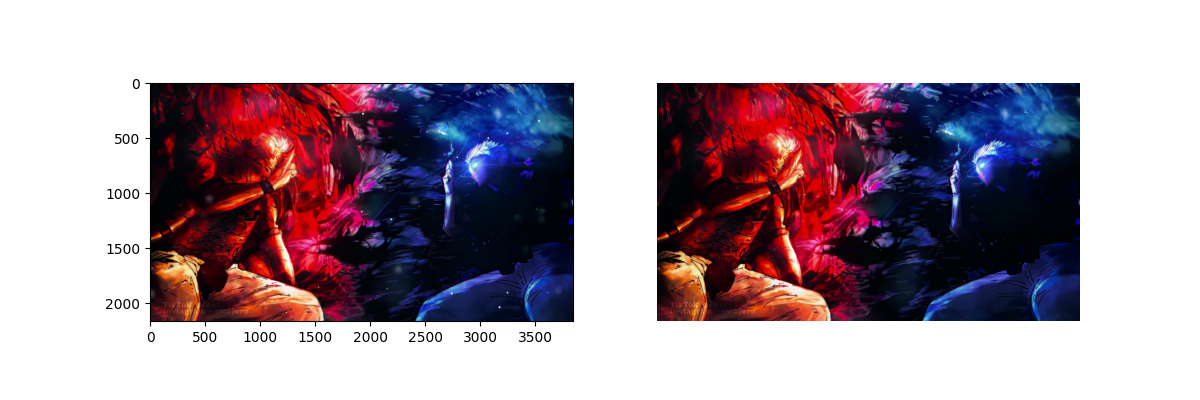

In [10]:
%matplotlib widget

import cv2
import matplotlib.pyplot as plt
import numpy as np
from ipywidgets import jslink, IntSlider, HBox, VBox, Play, Layout, Label
from matplotlib.animation import FuncAnimation

def blank_image(width=1920, height=1080):
    return np.zeros((height, width, 3), dtype=np.uint8)

def get_total_frames(post):
    cap = cv2.VideoCapture(post['path'])
    total = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    cap.release()
    return total

def preload_frames(video_path):
    cap = cv2.VideoCapture(video_path)
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    frames = []
    for i in range(frame_count):
        ret, frame = cap.read()
        if ret:
            # frames.append(frame)
            frames.append(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        else:
            # frames.append(blank_image())
            frames.append(cv2.cvtColor(blank_image()))
    cap.release()
    return frames

def plot_media():
    num_plots = len(media_links)
    frame_cache = preload_frames(media_links[0]['path'])
    current_max = len(frame_cache)
    current_sample_idx = 0
    current_frame_idx = 0

    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    fig.set_label(' ')  # remove "Figure #" label, can't be empty string

    sample_slider = IntSlider(min=0, max=num_plots-1, value=current_sample_idx, description='Sample #:', readout=True, layout=Layout(width='60%'))
    total_samples_label = Label(value=f'/{num_plots}', layout=Layout(width='auto'))
    frame_slider = IntSlider(min=0, max=current_max-1, value=current_frame_idx, continuous_update=False, description='Frame #:', readout=True, layout=Layout(width='60%'))
    total_frames_label = Label(value=f'/{current_max}', layout=Layout(width='auto'))
    play_button = Play(value=0, min=0, max=current_max-1, step=1, interval=13.33, description='Play', disabled=False, layout=Layout(width='auto', margin='0 0 0 10px'))

    dynamic_frame = frame_cache[current_frame_idx]
    size_label = Label(value=f"({dynamic_frame.shape[1]}x{dynamic_frame.shape[0]})")
    post_label = Label(value=media_links[current_sample_idx]['path'])

    def update_plot(sample_idx, frame_idx):
        nonlocal frame_cache, current_max, current_sample_idx, current_frame_idx

        current_sample_idx = sample_idx

        # Load the static image (frame 50 of the selected video)
        static_frame = frame_cache[50]
        # Update static plot
        axes[0].clear()
        axes[0].imshow(static_frame)

        # Load the dynamic frame
        dynamic_frame = frame_cache[frame_idx]

        axes[1].clear()  # Clear the dynamic plot
        axes[1].imshow(dynamic_frame)
        axes[1].axis('off')

        fig.canvas.draw()

    def on_sample_change(change):
        nonlocal frame_cache, current_max, current_frame_idx, axes
        sample_idx_local = change['new']
        frame_cache = preload_frames(media_links[sample_idx_local]['path'])
        current_max = len(frame_cache)
        frame_slider.max = current_max
        play_button.max = current_max
        current_frame_idx = 0
        frame_slider.value = current_frame_idx
        total_frames_label.value = f'/{current_max}'
        post_label.value = media_links[sample_idx_local]['path']
        size_label.value = f"({frame_cache[current_frame_idx].shape[1]}x{frame_cache[current_frame_idx].shape[0]})"
        update_plot(sample_idx_local, current_frame_idx)

    def on_frame_change(change):
        nonlocal current_frame_idx
        current_frame_idx = change['new']
        update_plot(sample_slider.value, change['new'])

    sample_slider.observe(on_sample_change, names='value')
    frame_slider.observe(on_frame_change, names='value')

    jslink((play_button, 'value'), (frame_slider, 'value'))

    sample_controller = HBox([sample_slider, total_samples_label], layout=Layout(justify_content='flex-start'))
    frame_controller = HBox([frame_slider, total_frames_label, play_button], layout=Layout(justify_content='flex-start'))
    controllers = VBox([sample_controller, frame_controller])
    display(controllers)
    display(HBox([size_label, post_label], layout=Layout(justify_content='center')))

    update_plot(current_sample_idx, current_frame_idx)
    

plot_media()